To explore this ipython notebook, press `SHIFT+ENTER` to progress to the next cell. Feel free to make changes, enter code, and hack around. You can create new code cells by selecting `INSERT->Insert Cell Below`

# MNIST Example

MNIST is a computer vision dataset consisting of 70,000 images of handwritten digits. Each image has 28x28 pixels for a total of 784 features, and is associated with a digit between 0-9.

<img src="http://corpocrat.com/wp-content/uploads/2014/10/figure_1.png" width=200px>


In this tutorial, we will construct a multi-layer perceptron (also called softmax regression) to recognize each image. Note that this tutorial assumes some basic familiarity with python and machine learning.

This tutorial is similar to the model specified in `examples/mnist_mlp.py`.

## Setup

This example works with Python 2.7. The urllib request method needs to be changed in the inference steps for Python 3.x.

Your environment needs to have the following packages installed:
- neon v1.8.1
- matplotlib (for the inference)

## Preamble
The first step is to set up our compute backend.

In [1]:
from neon.backends import gen_backend

be = gen_backend(batch_size=128)

The MNIST dataset can be found on Yann LeCunn’s website. We have included an easy function that downloads the MNIST dataset into your `~/nervana/data/` directory, loads it into memory, and returns `ArrayIterator` objects for the training and validation set.

In [2]:
from neon.data import MNIST

mnist = MNIST(path='/notebook/data/')
train_set = mnist.train_iter
valid_set = mnist.valid_iter

During training, neon iterates over the training examples to compute the gradients. The `train_iter` and `valid_iter` handle sending data to the model for training and validation, respectively.

For small datasets like MNIST, this step may seem trivial. However, for large datasets that cannot fit into memory (e.g. ImageNet or Sports-1M), the data has to be efficiently loaded and fed to the optimizer in batches. This requires more advanced iterators described in Loading data.

## Model specification
Training a deep learning model in Neon requires 
* Specifying the dataset
* Building a model from a list of layers
* Cost function
* Learning rule. 

Here we guide you through each item in turn.

### Initializing weights
Neon supports many ways of initializing weight matrices. In this tutorial, we initialize the weights using a Gaussian distribution with zero mean and 0.01 standard deviation.

In [3]:
from neon.initializers import Gaussian

init_norm = Gaussian(loc=0.0, scale=0.01)

### Model architecture
The model is specified as a list of layers. For classifying MNIST images, we use a multi-layer perceptron with fully connected layers.

- Affine (i.e. fully-connected) layer with 100 hidden units and a rectified linear activation function, defined as Rectlin().
- An output layer with 10 units to match the number of labels in the MNIST dataset. We use the Softmax() activation function to ensure the outputs sum to one and are within the range [0,1].



In [4]:
from neon.layers import Affine
from neon.transforms import Rectlin, Softmax

layers = []
layers.append(Affine(nout=100, init=init_norm, activation=Rectlin()))
layers.append(Affine(nout=10, init=init_norm,
                     activation=Softmax()))

We initialize the weights in each layer with the init_norm defined previously. Neon supports many other layer types (convolutional, pooling, recurrent, etc.) that will be described in subsequent examples. We then construct the model via

In [5]:
# initialize model object
from neon.models import Model

mlp = Model(layers=layers)

### Costs
The cost function is wrapped within a GeneralizedCost layer, which handles the comparison of the outputs with the provided labels in the dataset. One common cost function which we use here is the cross entropy loss.

In [6]:
from neon.layers import GeneralizedCost
from neon.transforms import CrossEntropyMulti

cost = GeneralizedCost(costfunc=CrossEntropyMulti())

### Learning rules
For learning, we use stochastic gradient descent with a learning rate of 0.1 and momentum coefficient of 0.9.



In [7]:
from neon.optimizers import GradientDescentMomentum

optimizer = GradientDescentMomentum(0.1, momentum_coef=0.9)

Callbacks
Neon provides an API for calling operations during the model fit (see Callbacks). Here we set up the default callback, which is displaying a progress bar for each epoch.


In [8]:
from neon.callbacks.callbacks import Callbacks

callbacks = Callbacks(mlp, eval_set=valid_set)


Putting it all together
We are ready to put all the ingredients together and run our model!

In [9]:
mlp.fit(train_set, optimizer=optimizer, num_epochs=10, cost=cost,
        callbacks=callbacks)

Epoch 0   [Train |████████████████████|  469/469  batches, 0.13 cost, 1.50s]
Epoch 1   [Train |████████████████████|  469/469  batches, 0.10 cost, 1.63s]
Epoch 2   [Train |████████████████████|  469/469  batches, 0.07 cost, 1.67s]
Epoch 3   [Train |████████████████████|  468/468  batches, 0.06 cost, 1.49s]
Epoch 4   [Train |████████████████████|  468/468  batches, 0.05 cost, 1.65s]
Epoch 5   [Train |████████████████████|  468/468  batches, 0.04 cost, 1.85s]
Epoch 6   [Train |████████████████████|  468/468  batches, 0.03 cost, 1.46s]
Epoch 7   [Train |████████████████████|  468/468  batches, 0.03 cost, 1.35s]
Epoch 8   [Train |████████████████████|  468/468  batches, 0.02 cost, 1.35s]
Epoch 9   [Train |████████████████████|  468/468  batches, 0.02 cost, 1.36s]


At the beginning of the fitting procedure, neon propagates train_set through the model to set the input and output shapes of each layer. Each layer has a `configure()` method that determines the appropriate layer shapes, and an `allocate()` method to set up the needed buffers for holding the forward propagation information.

During the training, neon sends batches of the training data through the model, calling each layers’ `fprop()` and `bprop()` methods to compute the gradients and update the weights.

### Using the trained model
Now that the model is successfully trained, we can use the trained model to classify a novel image, measure performance, and visualize the weights and training results.

#### Get outputs
Given a set of images such as those contained in the iterable `test_set`, we can fetch the ouput of the final model layer via



In [10]:
results = mlp.get_outputs(valid_set)

The variable results is a numpy array with shape `(num_test_examples, num_outputs) = (10000,10)` with the model probabilities for each label.

#### Performance
Neon supports convenience functions for evaluating performance using custom metrics. Here we measure the misclassification rate on the held out test set.

In [11]:
from neon.transforms import Misclassification

# evaluate the model on test_set using the misclassification metric
error = mlp.eval(valid_set, metric=Misclassification())*100
print('Misclassification error = %.1f%%' % error)

Misclassification error = 2.6%


## Inference

Now let's download a new digit image from the web, and use our trained model to recognize the digit. We first download the image and scale it to the 28x28 pixels that our model expects.

In [12]:
import urllib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# download image
url = "http://datawrangling.s3.amazonaws.com/sample_digit.png"
urllib.urlretrieve(url, filename="/notebook/data/digit.jpg")

# scale to 28x28 pixels
img = Image.open("/notebook/data/digit.jpg")
img.thumbnail((28, 28))

digit = np.asarray(img, dtype=np.float32)[:, :, 0]

# reshape to a single feature vector
digit = digit.reshape(784, 1)

# store digit into a GPU tensor
x_new = be.zeros((28*28, 128), dtype=np.float32)
x_new[:, 0] = digit



Model final layer was: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
The most probable guess is digit: 4


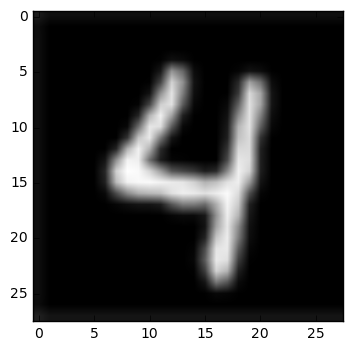

In [13]:
# forward pass through the model
outputs = mlp.fprop(x_new)
outputs = outputs.get()[:, 0]

# examine the output of the model for this image
print "Model final layer was: {}".format(outputs)
print "The most probable guess is digit: {}".format(np.argmax(outputs))
plt.figure(2)
plt.imshow(img)
